In [40]:
import os

import pandas as pd
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot


# Load Data

In [2]:
data_folder = 'data'

In [3]:
train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test = pd.read_csv(os.path.join(data_folder, "test.csv"))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [6]:
train.head()

id        date country              store             product  num_sold
0   0  2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1   1  2010-01-01  Canada  Discount Stickers              Kaggle     973.0
2   2  2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
3   3  2010-01-01  Canada  Discount Stickers            Kerneler     423.0
4   4  2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [8]:
# cast date column

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# EDA

### Null-values

Some of the target values in train set is missing

In [10]:
train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [11]:
test.isnull().sum()

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [17]:
train[train['num_sold'].isnull()].groupby(['country', 'store', 'product']).count()

id  date  num_sold
country store                product                                 
Canada  Discount Stickers    Holographic Goose   2557  2557         0
                             Kerneler               1     1         0
        Premium Sticker Mart Holographic Goose    380   380         0
        Stickers for Less    Holographic Goose   1308  1308         0
Kenya   Discount Stickers    Holographic Goose   2557  2557         0
                             Kerneler              63    63         0
                             Kerneler Dark Mode     1     1         0
        Premium Sticker Mart Holographic Goose    646   646         0
        Stickers for Less    Holographic Goose   1358  1358         0

### Time Series Distribution

In [36]:
def plot_grouped_time_series(df, grouped_by = ['store', 'product'], x_axis = 'date', y_axis = 'num_sold', title = 'TITLE'):
    '''
    Group by the columns in groupd_by
    plot a series of y_axis vs. x_axis for each group
    '''
    fig, ax = plt.subplots()

    for group_columns, group in df.groupby(grouped_by):
        group.plot(x=x_axis, y=y_axis, ax=ax, label=group_columns)

    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend(title=f'Grouped by: {grouped_by}', bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.tight_layout()
    plt.show()

def plot_single_serie(df, date_col = 'date', quant_col = 'num_sold'):
    # Plotting the time series
    plt.figure(figsize=(10, 6))
    if df.index.name == date_col:
        plt.plot(df.index, df[quant_col], marker='o', color='b', linestyle='-')
    else:
        plt.plot(df[date_col], df[quant_col], marker='o', color='b', linestyle='-')
    plt.title(f'Time Series of {quant_col}')
    plt.xlabel(date_col)
    plt.ylabel(quant_col)
    plt.grid(True)
    plt.show()

##### Group by country and store

1. The scale of `num_sold` vary across countries and stores (e.g. 200-1500 level in Canada v.s. 5-100 level in Kenya)
2. The relative distribution among different products is visually-similar across different `(country, store)` groups

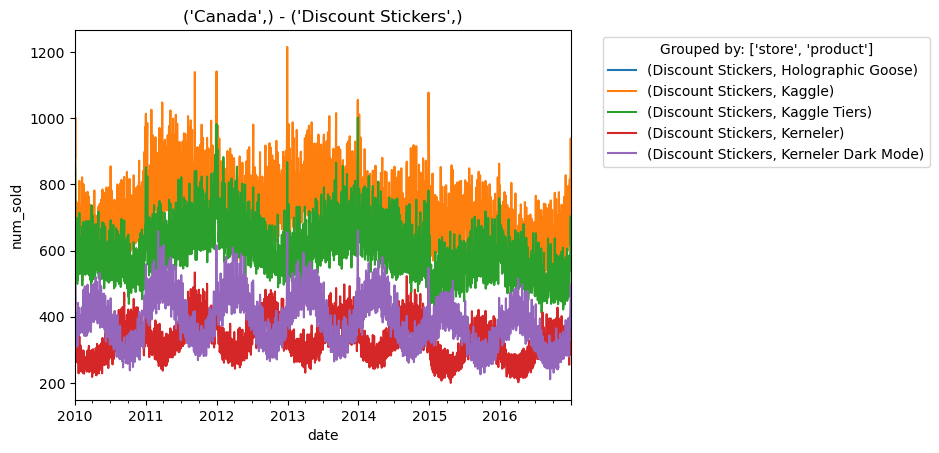

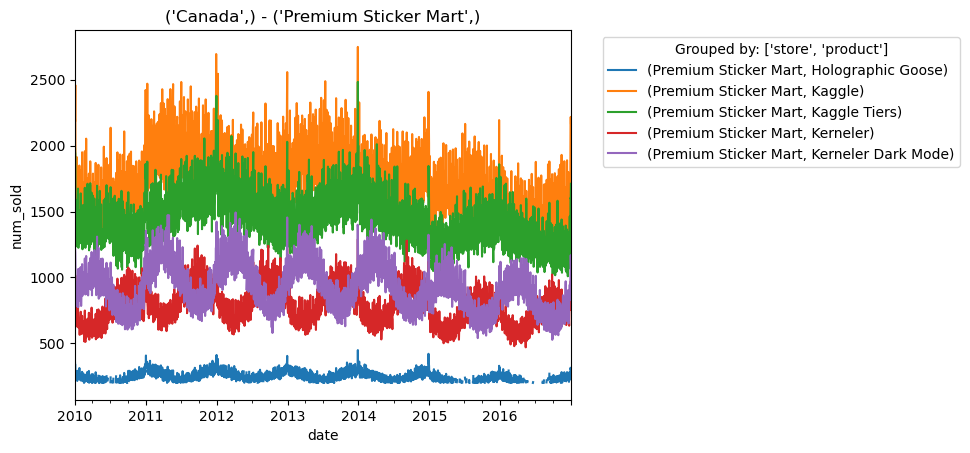

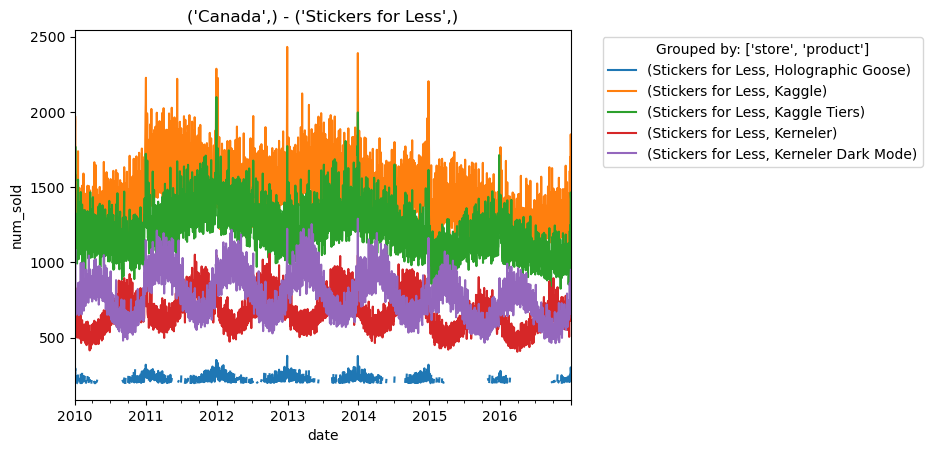

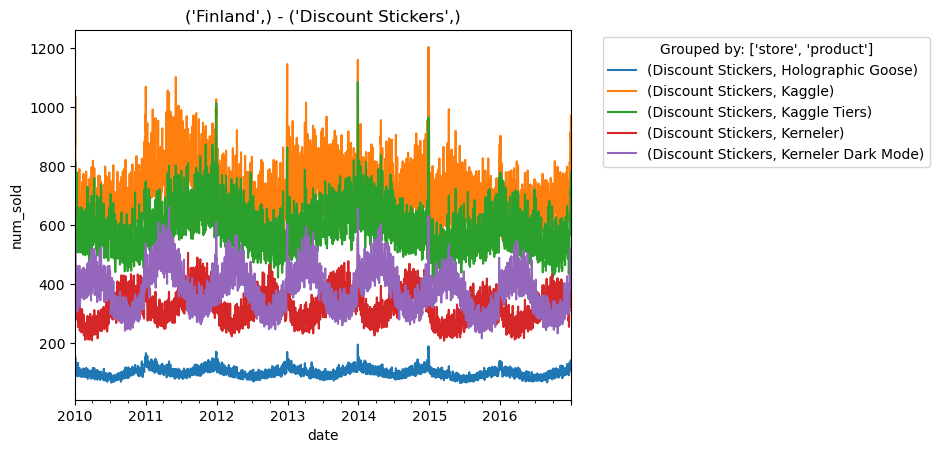

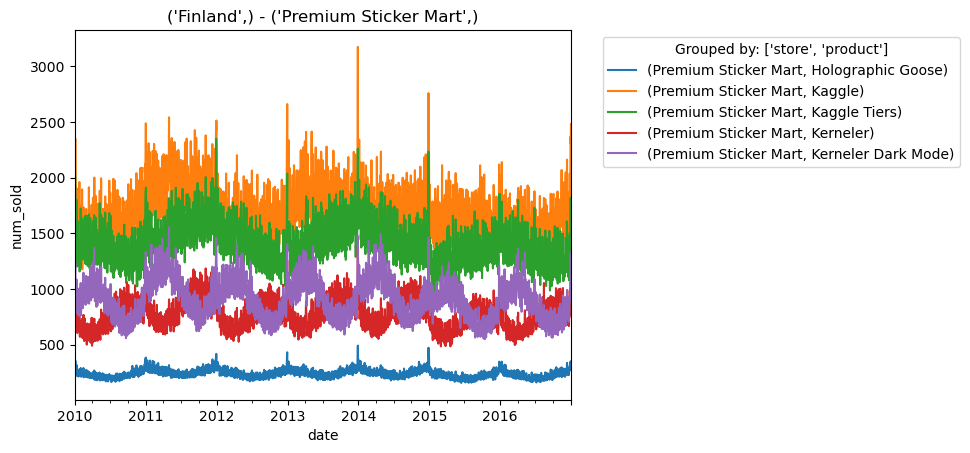

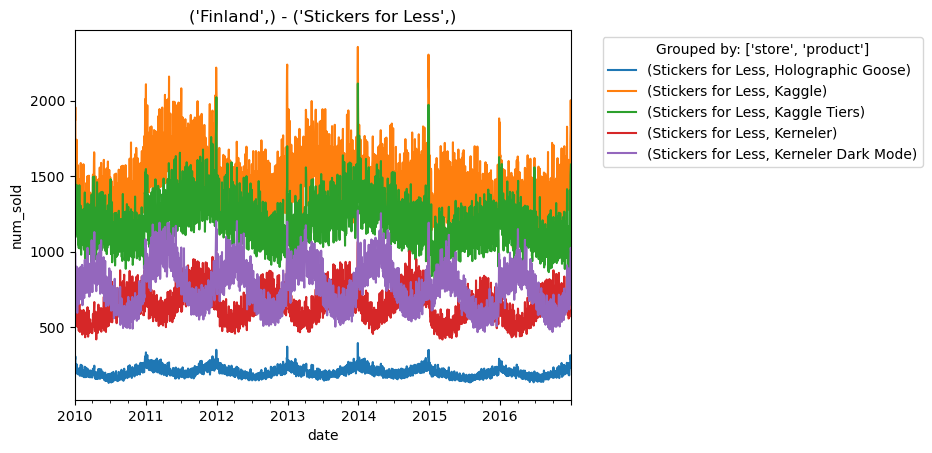

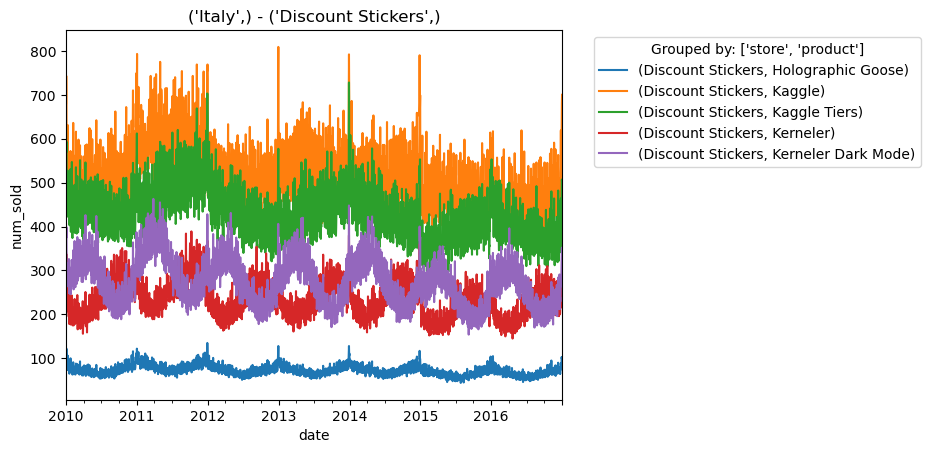

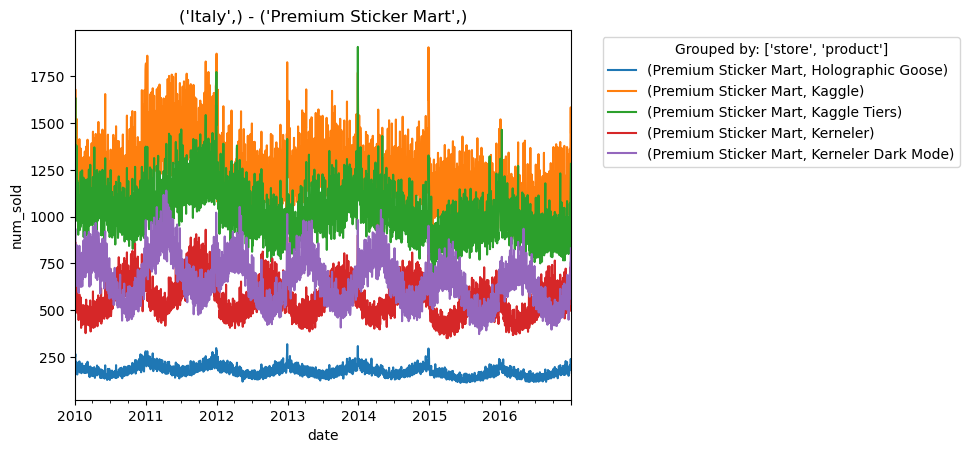

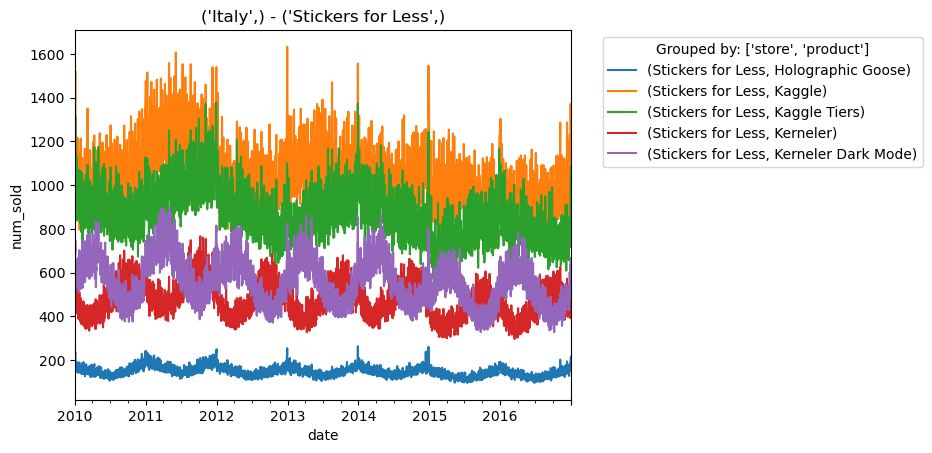

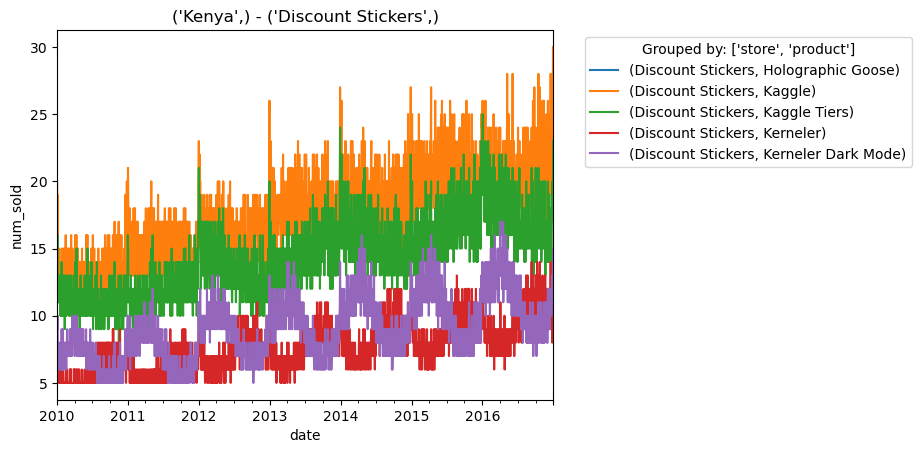

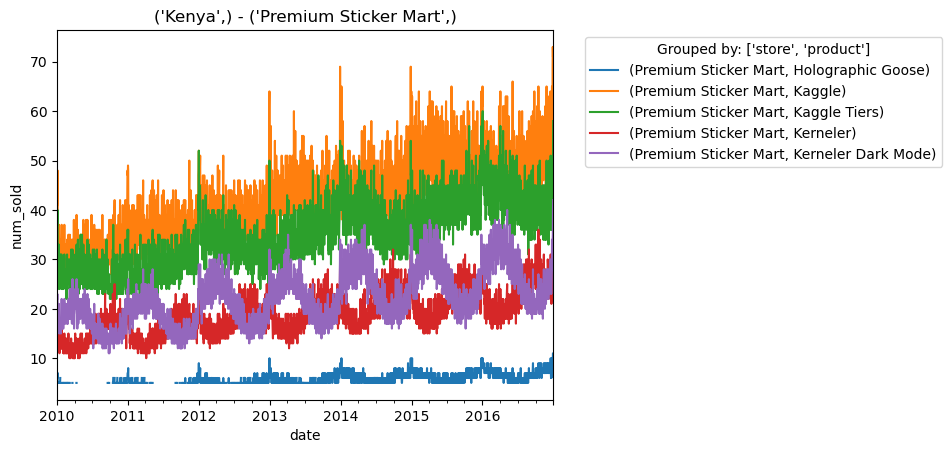

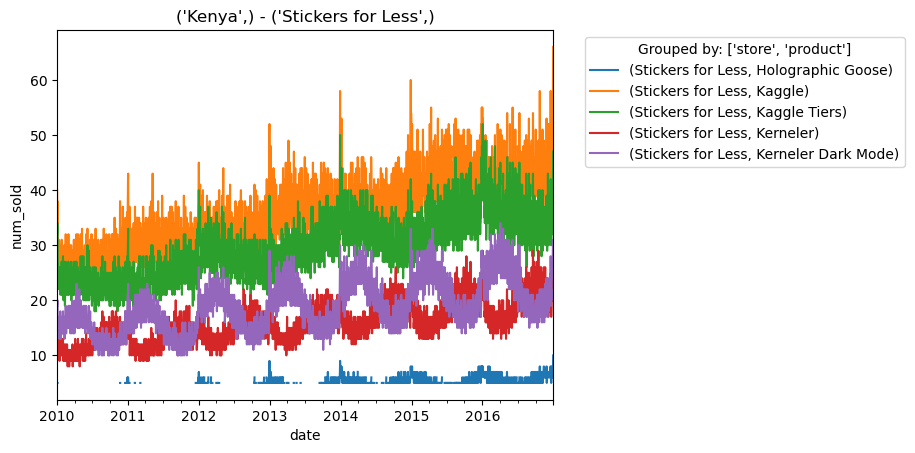

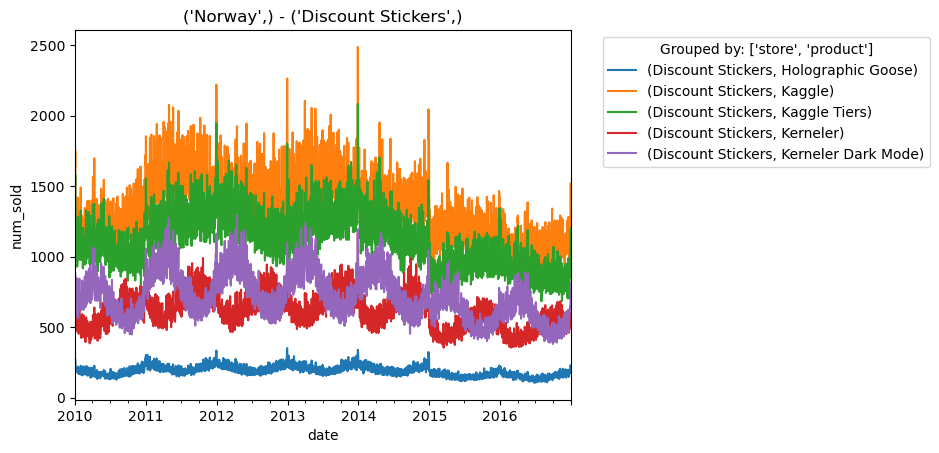

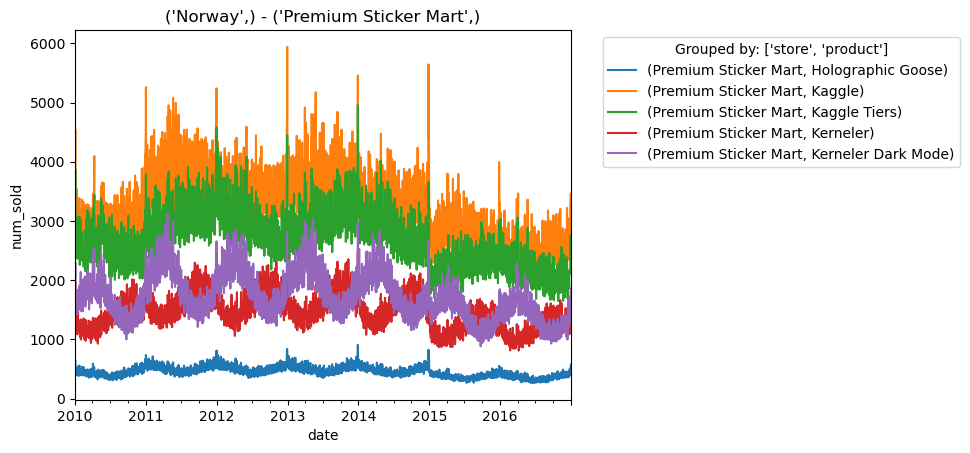

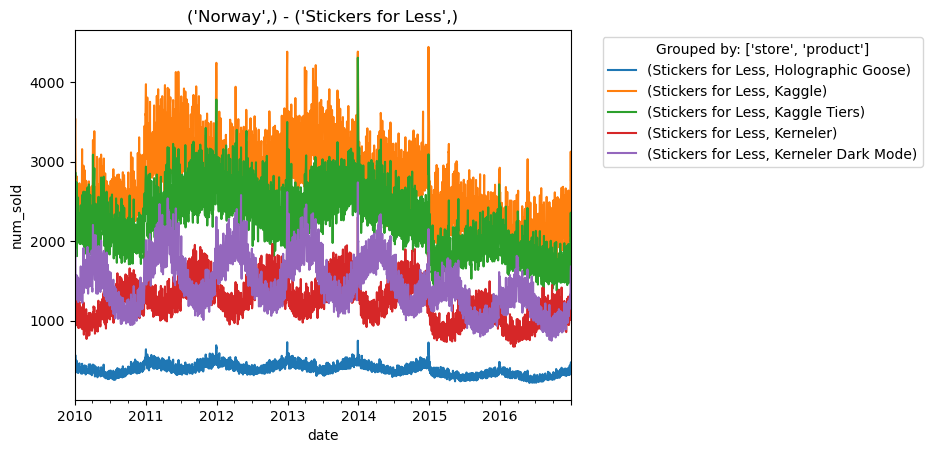

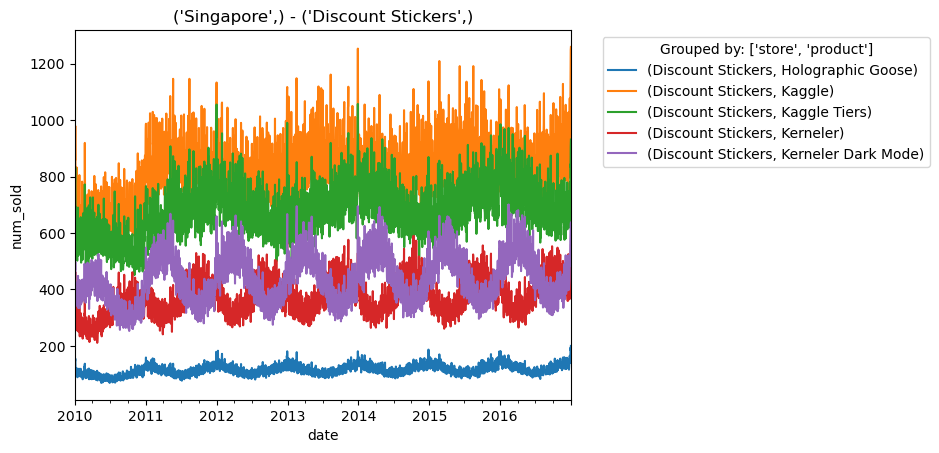

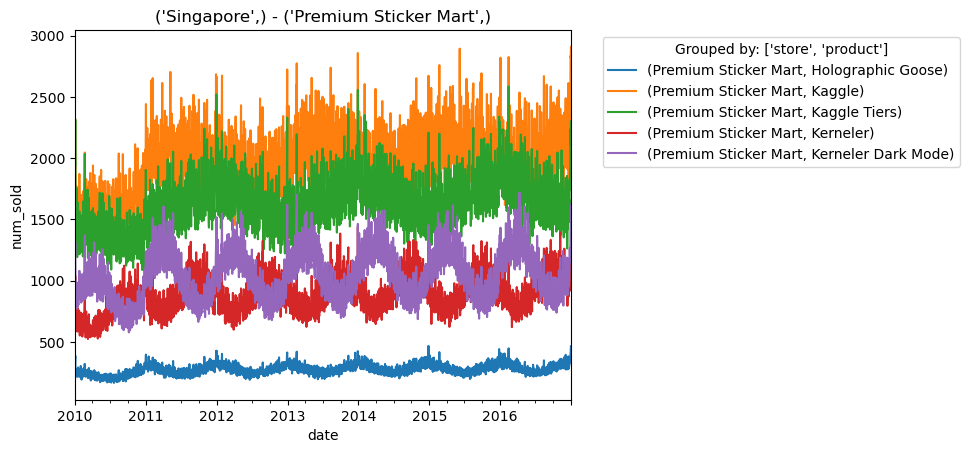

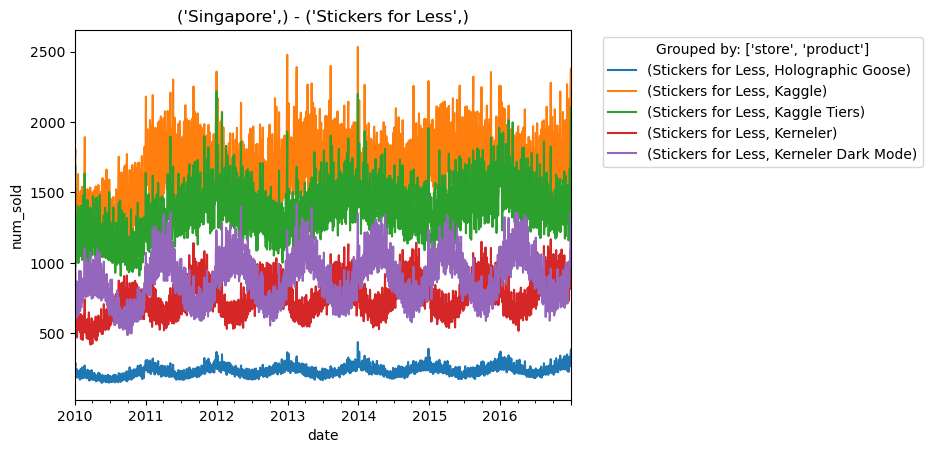

In [34]:
for country, country_df in train.groupby(['country']):
    for store, country_store_df in country_df.groupby(['store']):
        plot_grouped_time_series(country_store_df, title = f'{country} - {store}')

##### Group by product


1. The general seasonality pattern for all products: increase in `num_sold` from mid-year to year-end culminating at spike during holiday seasons, decrease from year-start to mid-year
2. The `num_sold` for the same `product` shows a similar seasonality pattern across different countries
3. Some products show stronger seasonality (Holographic Goose, Kerneler and dark mode) than others

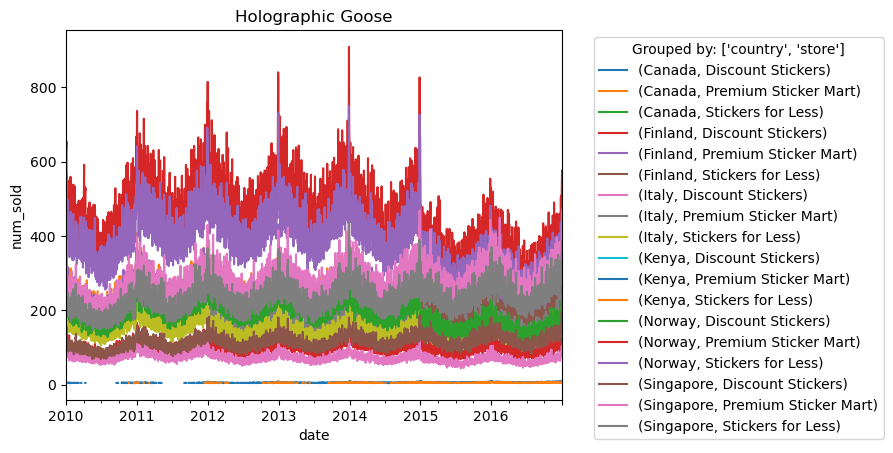

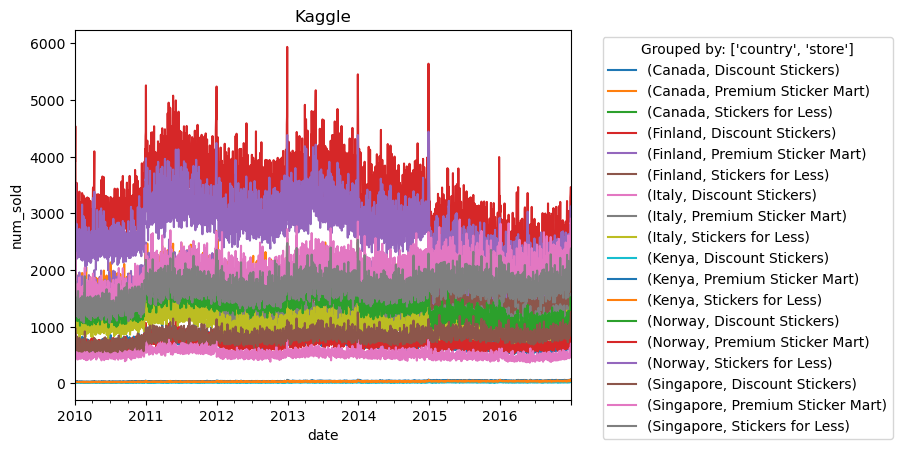

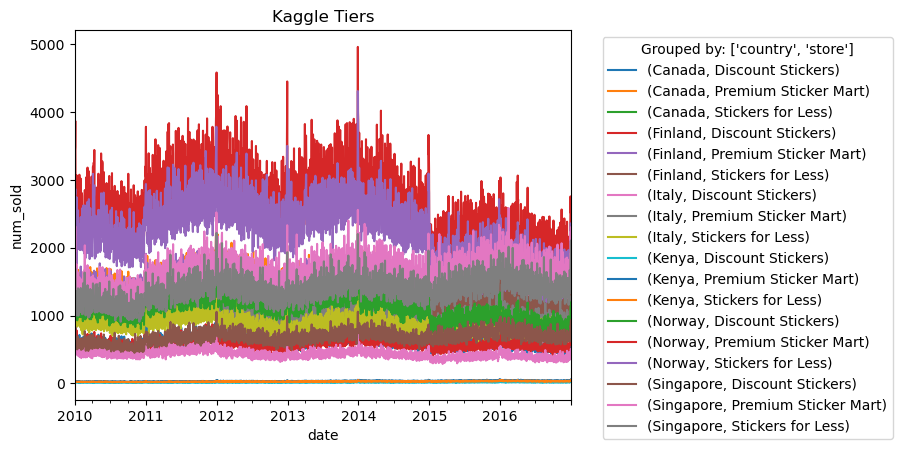

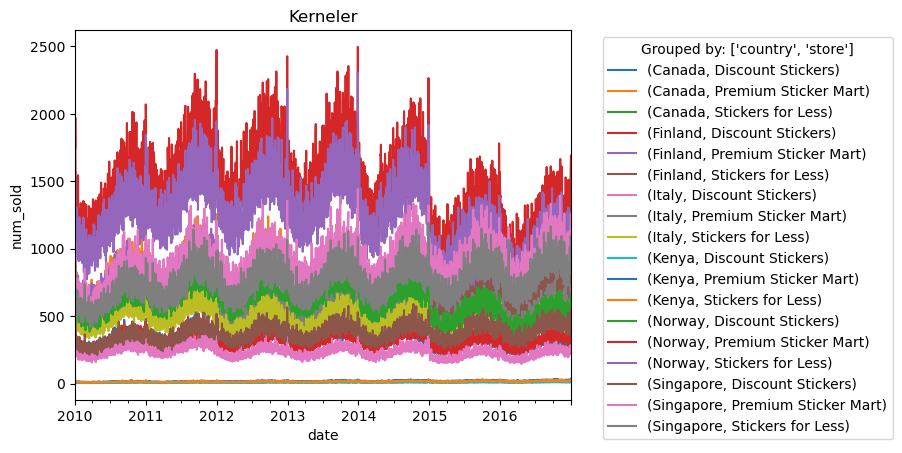

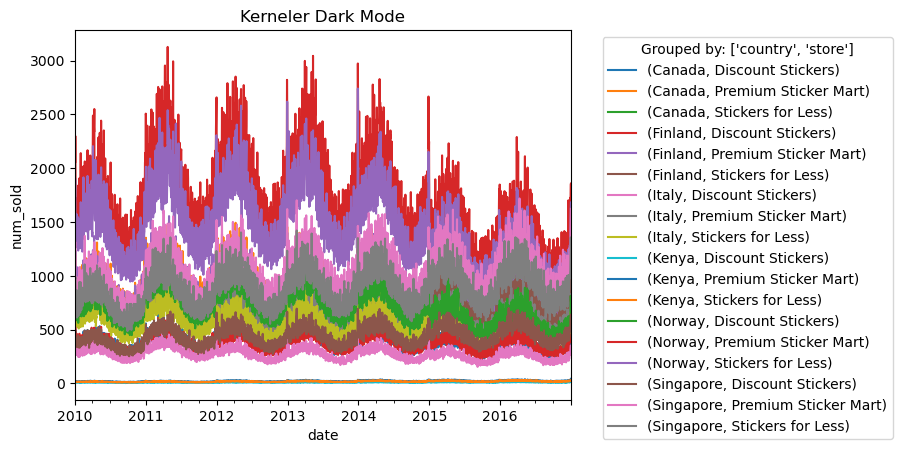

In [23]:
for product, product_df in train.groupby(['product']):
    plot_grouped_time_series(product_df, grouped_by = ['country', 'store'], x_axis = 'date', y_axis = 'num_sold', title = product[0])

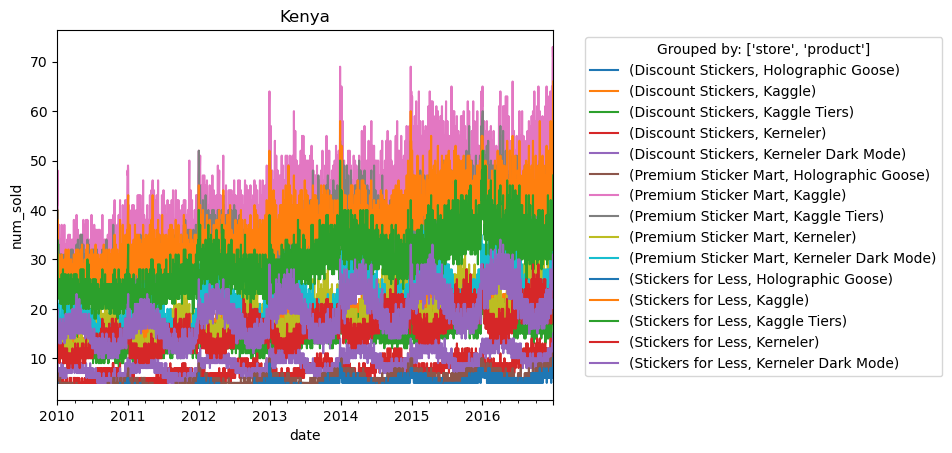

Zoom in a bit on Kenya sales. The general pattern still holds.

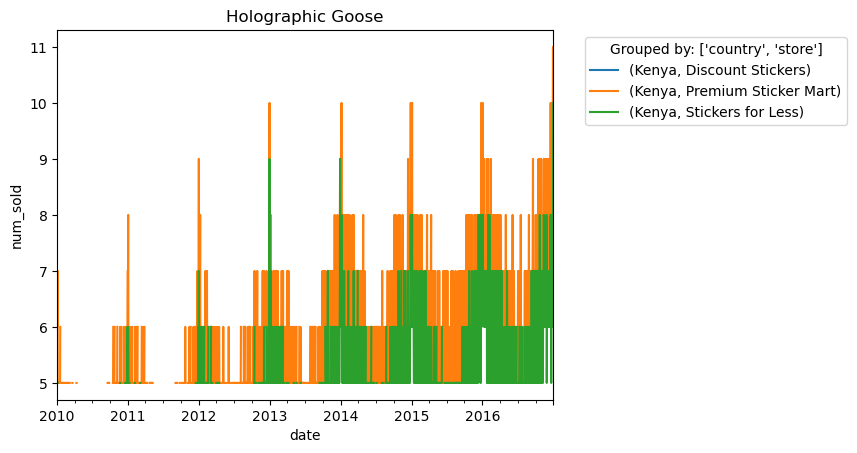

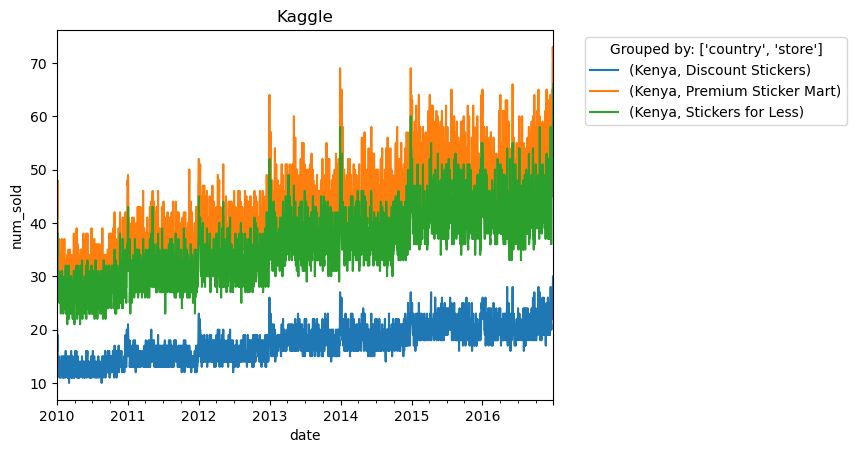

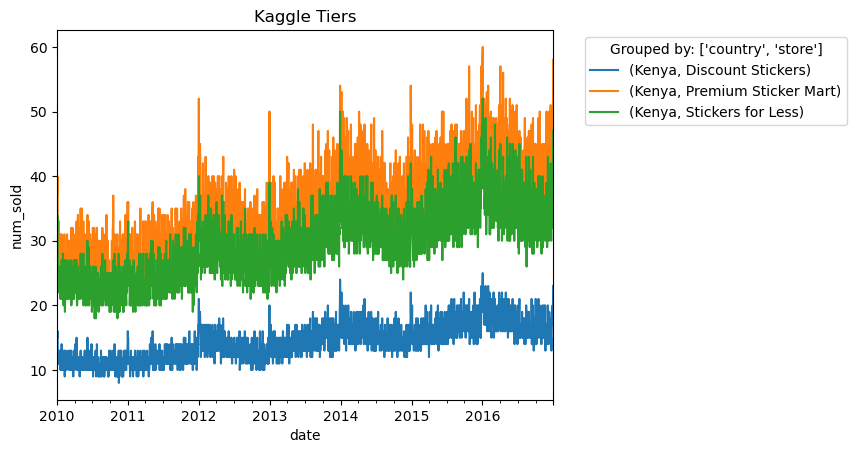

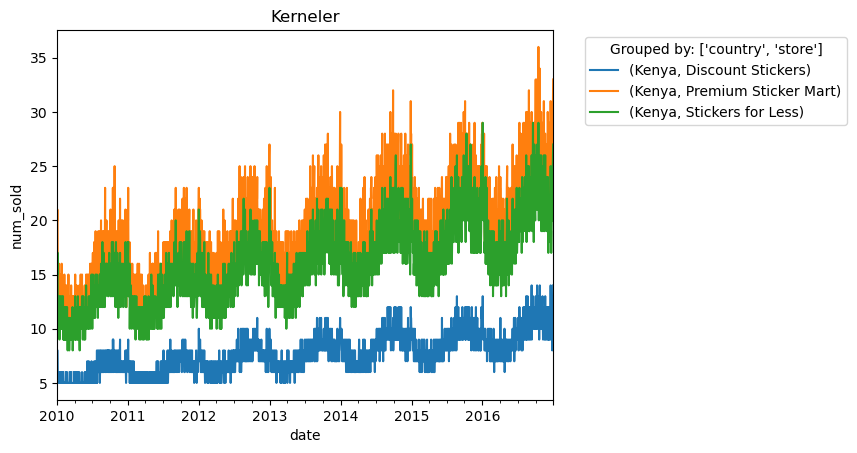

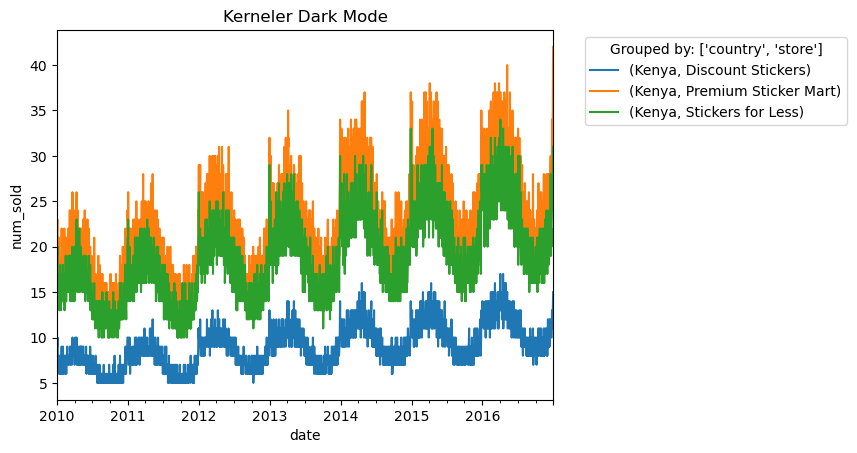

In [25]:
for product, product_df in train[train['country'] == 'Kenya'].groupby(['product']):
    plot_grouped_time_series(product_df, grouped_by = ['country', 'store'], x_axis = 'date', y_axis = 'num_sold', title = product[0])

# Data Preprocessing

### Impute Missing Values

In [61]:
groups_w_missing_value = train[train['num_sold'].isnull()].groupby(['country', 'store', 'product']).count().index
groups_w_missing_value

MultiIndex([('Canada',    'Discount Stickers',  'Holographic Goose'),
            ('Canada',    'Discount Stickers',           'Kerneler'),
            ('Canada', 'Premium Sticker Mart',  'Holographic Goose'),
            ('Canada',    'Stickers for Less',  'Holographic Goose'),
            ( 'Kenya',    'Discount Stickers',  'Holographic Goose'),
            ( 'Kenya',    'Discount Stickers',           'Kerneler'),
            ( 'Kenya',    'Discount Stickers', 'Kerneler Dark Mode'),
            ( 'Kenya', 'Premium Sticker Mart',  'Holographic Goose'),
            ( 'Kenya',    'Stickers for Less',  'Holographic Goose')],
           names=['country', 'store', 'product'])

In [65]:
train['num_sold_linear_imputed'] = train['num_sold']
train['num_sold_spline_imputed'] = train['num_sold']
train['num_sold_STL_linear_imputed'] = train['num_sold']
train['num_sold_STL_spline_imputed'] = train['num_sold']

In [75]:
def impute(df, missing_column = 'num_sold', method = 'linear',seasonal_period = None, base_interpolate_method = None):
    '''
    
    '''
    df_copy = df.copy()

    # Fill missing values in the time series
    imputed_indices = df[df[missing_column].isnull()].index

    if method == 'linear':
        df_imputed = df_copy[missing_column].interpolate(method = method)
    elif method == 'spline':
        df_imputed = df_copy[missing_column].interpolate(method = method, order = 3)
    elif method == 'STL':
        # Apply STL decompostion
        assert seasonal_period > 0
        assert type(base_interpolate_method) == str and base_interpolate_method in ['linear', 'spline']

        # Interpolate using a base method first to extract the seasonal component
        stl = STL(df_copy[missing_column].interpolate(method = base_interpolate_method, order = 3), period = seasonal_period)
        res = stl.fit()
        seasonal_component = res.seasonal

        # Interpolate the deseasonalized series
        df_deseasonalised = df_copy[missing_column] - seasonal_component
        df_deseasonalised_imputed = df_deseasonalised.interpolate(method=base_interpolate_method, order = 3)

        # Add the seasonal component back
        df_imputed = df_deseasonalised_imputed + seasonal_component

    return imputed_indices, df_imputed

In [76]:
for country, store, product in groups_w_missing_value:
    filtered_df = train[(train['country'] == country) & (train['store'] == store) & (train['product'] == product)]
    
    for method in ['linear', 'spline', 'STL']:
        if method == 'STL':
            for base_method in ['linear', 'spline']:
                imputed_indices, df_imputed = impute(filtered_df, method = method, seasonal_period=365, base_interpolate_method = base_method)
                
                train.loc[imputed_indices, f'num_sold_{method}_{base_method}_imputed'] = df_imputed[imputed_indices]
        else:
            imputed_indices, df_imputed = impute(filtered_df, method = method)
            train.loc[imputed_indices, f'num_sold_{method}_imputed'] = df_imputed[imputed_indices]

Take a look at the imputed series

In [ ]:
def plot_imputed_series(df, imputed_indices, x = 'date', y = 'num_sold', title = 'Imputation'):
    plt.figure(figsize=[20, 6])

    # plot the complete series
    df.plot(x =x, y = y, style='.-',  label=y)

    # specifically mark out the imputed values
    plt.scatter(df.loc[imputed_indices, x], df.loc[imputed_indices, y], color='red')

    plt.title(title)
    plt.ylabel(x)
    plt.xlabel(y)
    plt.show()

<Figure size 2000x600 with 0 Axes>

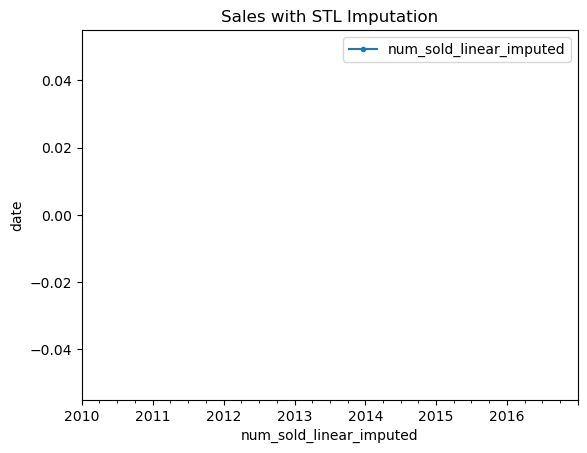

<Figure size 2000x600 with 0 Axes>

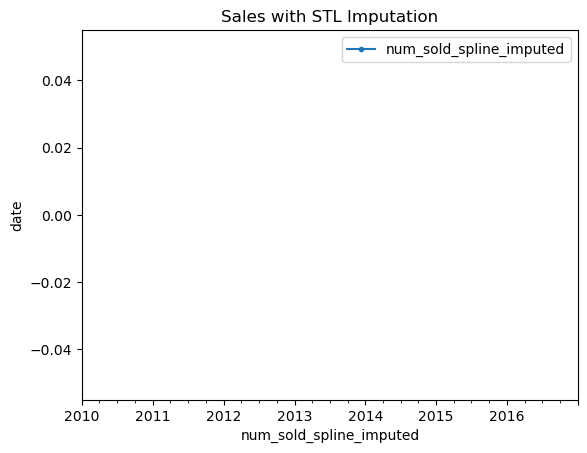

<Figure size 2000x600 with 0 Axes>

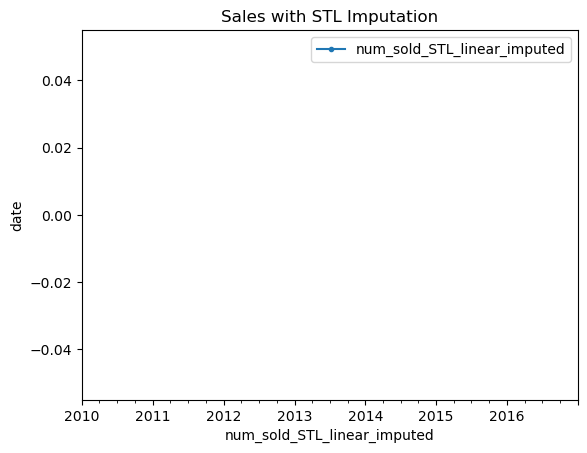

<Figure size 2000x600 with 0 Axes>

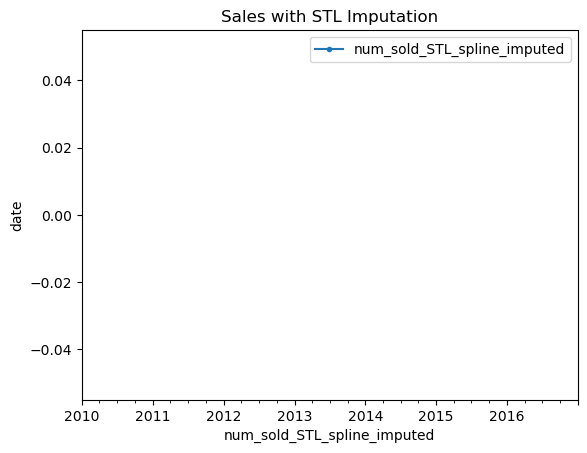

<Figure size 2000x600 with 0 Axes>

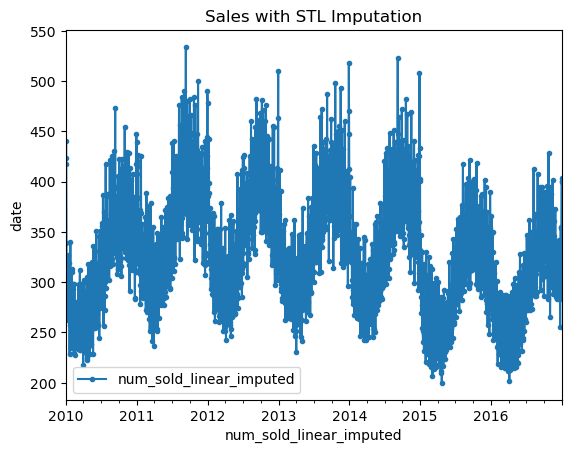

<Figure size 2000x600 with 0 Axes>

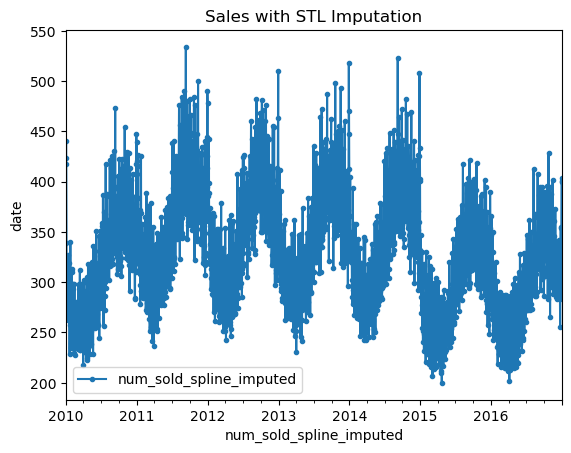

<Figure size 2000x600 with 0 Axes>

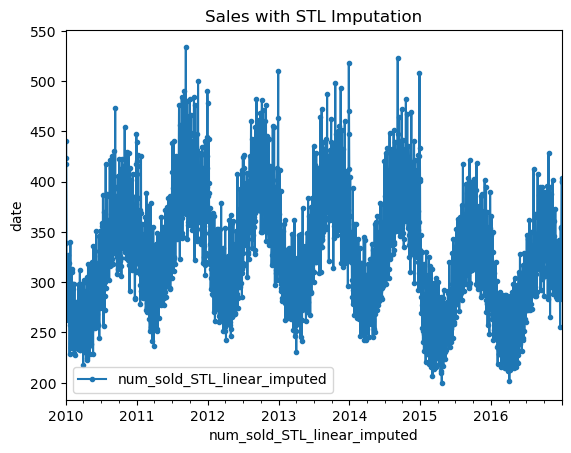

<Figure size 2000x600 with 0 Axes>

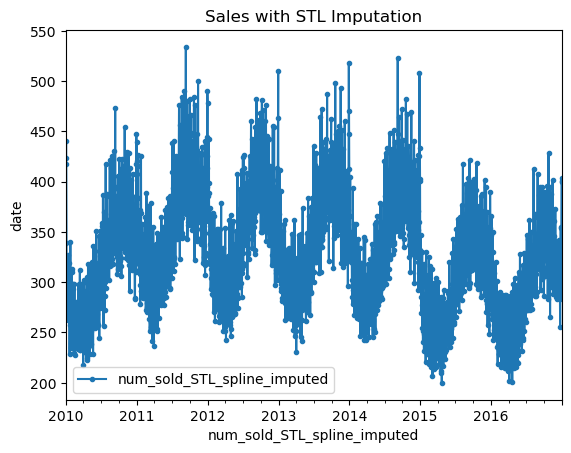

<Figure size 2000x600 with 0 Axes>

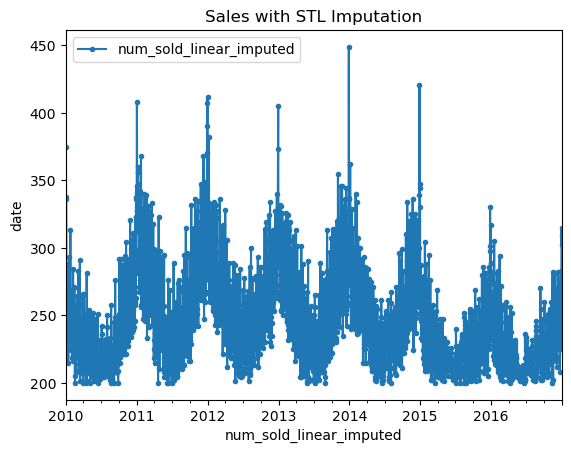

<Figure size 2000x600 with 0 Axes>

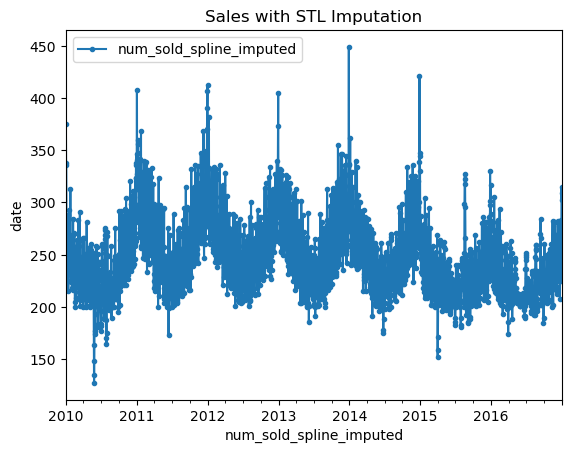

<Figure size 2000x600 with 0 Axes>

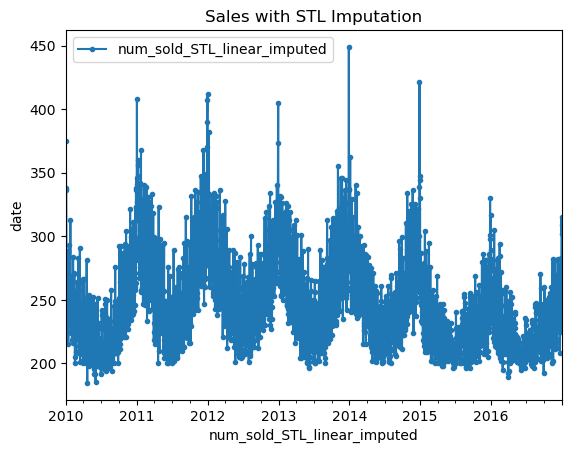

<Figure size 2000x600 with 0 Axes>

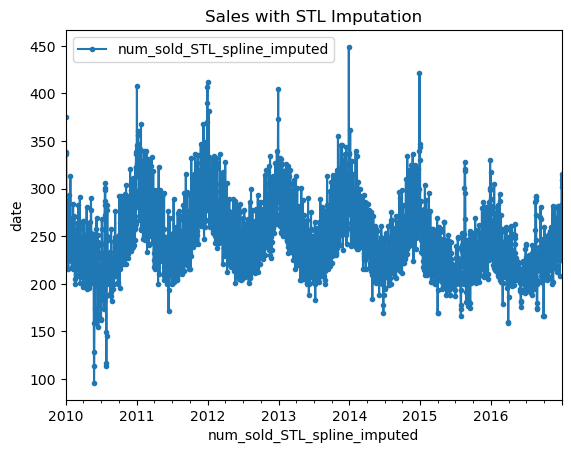

<Figure size 2000x600 with 0 Axes>

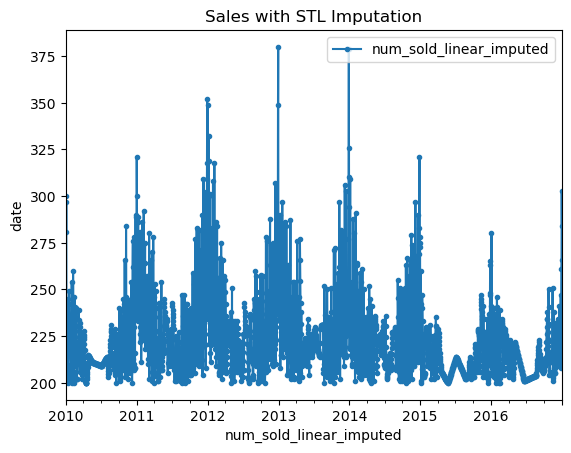

<Figure size 2000x600 with 0 Axes>

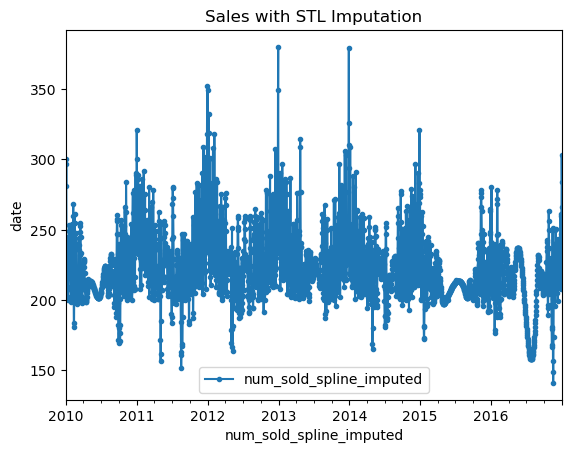

<Figure size 2000x600 with 0 Axes>

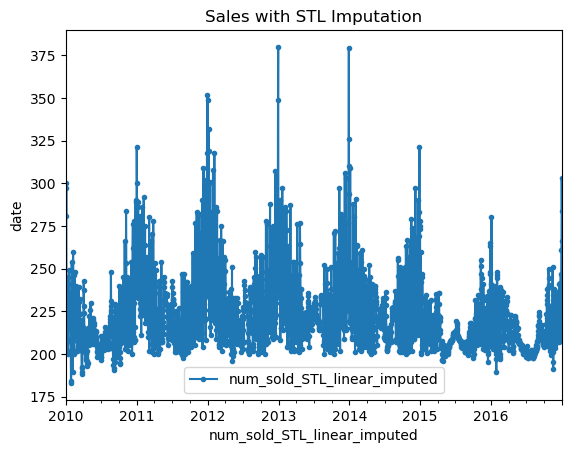

<Figure size 2000x600 with 0 Axes>

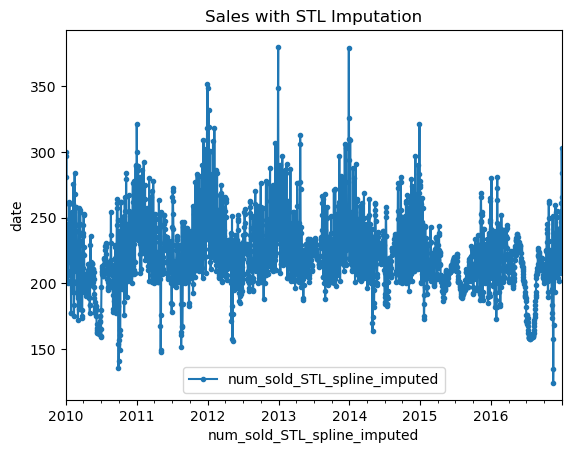

<Figure size 2000x600 with 0 Axes>

KeyboardInterrupt: 

In [80]:
for country, store, product in groups_w_missing_value:
    filtered_df = train[(train['country'] == country) & (train['store'] == store) & (train['product'] == product)]
    imputed_indices = filtered_df[filtered_df['num_sold'].isnull()].index

    for imputed_column in ['num_sold_linear_imputed', 'num_sold_spline_imputed', 'num_sold_STL_linear_imputed', 'num_sold_STL_spline_imputed']:
        plot_imputed_series(filtered_df, imputed_indices, y = imputed_column, title = imputed_column)

In [ ]:
train['num_sold_linear_imputed'] = train['num_sold']
train['num_sold_spline_imputed'] = train['num_sold']
train['num_sold_STL_linear_imputed'] = train['num_sold']
train['num_sold_STL_spline_imputed'] = train['num_sold']